In [9]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [10]:
%matplotlib inline

In [11]:
env = gym.make('LunarLander-v2',continuous = True)

In [12]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = 6

episode_n = 1000
t_max = 1000

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/2000)
action_dict = [[0,0],[1,0],[1,-1],[1,1],[0,1],[0,-1]]

hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action_dict[action[0]])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -92.33, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 1, mem: 70
episode: 1, rew: -236.22, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 1.0, mem: 197
episode: 2, rew: -311.38, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 1.0, mem: 370
episode: 3, rew: -240.8, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 0.99, mem: 509
episode: 4, rew: -271.48, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 0.99, mem: 590
episode: 5, rew: -268.62, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 0.99, mem: 676
episode: 6, rew: -271.0, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 0.99, mem: 804
episode: 7, rew: -312.99, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 0.99, mem: 927
episode: 8, rew: -299.06, v_: -85.21, v_disc_: -56.55, v: -594.66, v_disc: -396.67, epsilon: 0.99, mem: 1022
episode: 9, rew: -318.23, v_: -85.21

episode: 74, rew: -301.83, v_: -380.06, v_disc_: -203.96, v: -438.39, v_disc: -247.76, epsilon: 0.84, mem: 10477
episode: 75, rew: -303.06, v_: -380.06, v_disc_: -203.96, v: -438.39, v_disc: -247.76, epsilon: 0.84, mem: 10662
episode: 76, rew: -298.52, v_: -380.06, v_disc_: -203.96, v: -438.39, v_disc: -247.76, epsilon: 0.84, mem: 10773
episode: 77, rew: -295.21, v_: -380.06, v_disc_: -203.96, v: -438.39, v_disc: -247.76, epsilon: 0.84, mem: 10898
episode: 78, rew: -291.04, v_: -380.06, v_disc_: -203.96, v: -438.39, v_disc: -247.76, epsilon: 0.84, mem: 11038
episode: 79, rew: -288.77, v_: -380.06, v_disc_: -203.96, v: -438.39, v_disc: -247.76, epsilon: 0.84, mem: 11117
episode: 80, rew: -288.0, v_: -343.68, v_disc_: -181.39, v: -395.29, v_disc: -218.71, epsilon: 0.83, mem: 11201
episode: 81, rew: -284.87, v_: -343.68, v_disc_: -181.39, v: -395.29, v_disc: -218.71, epsilon: 0.83, mem: 11425
episode: 82, rew: -281.86, v_: -343.68, v_disc_: -181.39, v: -395.29, v_disc: -218.71, epsilon: 0

episode: 148, rew: -172.57, v_: -143.13, v_disc_: 10.78, v: -155.74, v_disc: 15.78, epsilon: 0.47, mem: 35316
episode: 149, rew: -170.61, v_: -143.13, v_disc_: 10.78, v: -155.74, v_disc: 15.78, epsilon: 0.46, mem: 36316
episode: 150, rew: -168.71, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.44, mem: 37316
episode: 151, rew: -164.37, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.43, mem: 38316
episode: 152, rew: -160.19, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.41, mem: 39316
episode: 153, rew: -154.41, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.4, mem: 40316
episode: 154, rew: -151.71, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.38, mem: 41316
episode: 155, rew: -146.57, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.37, mem: 42316
episode: 156, rew: -143.09, v_: -130.97, v_disc_: 21.32, v: -161.66, v_disc: 18.04, epsilon: 0.35, mem: 43316
episode: 15

episode: 224, rew: -110.3, v_: -23.9, v_disc_: 45.98, v: -64.22, v_disc: 43.32, epsilon: 0.03, mem: 103733
episode: 225, rew: -107.51, v_: -23.9, v_disc_: 45.98, v: -64.22, v_disc: 43.32, epsilon: 0.03, mem: 104733
episode: 226, rew: -106.54, v_: -23.9, v_disc_: 45.98, v: -64.22, v_disc: 43.32, epsilon: 0.03, mem: 105733
episode: 227, rew: -105.96, v_: -23.9, v_disc_: 45.98, v: -64.22, v_disc: 43.32, epsilon: 0.03, mem: 106733
episode: 228, rew: -105.71, v_: -23.9, v_disc_: 45.98, v: -64.22, v_disc: 43.32, epsilon: 0.03, mem: 107157
episode: 229, rew: -104.13, v_: -23.9, v_disc_: 45.98, v: -64.22, v_disc: 43.32, epsilon: 0.03, mem: 108157
episode: 230, rew: -101.14, v_: -38.38, v_disc_: 40.25, v: -77.0, v_disc: 38.46, epsilon: 0.03, mem: 109157
episode: 231, rew: -95.54, v_: -38.38, v_disc_: 40.25, v: -77.0, v_disc: 38.46, epsilon: 0.03, mem: 109559
episode: 232, rew: -88.35, v_: -38.38, v_disc_: 40.25, v: -77.0, v_disc: 38.46, epsilon: 0.03, mem: 109932
episode: 233, rew: -86.23, v_: 

episode: 301, rew: 33.26, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 149780
clear memory
episode: 302, rew: 35.92, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 135288
episode: 303, rew: 37.55, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 135940
episode: 304, rew: 40.33, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 136246
episode: 305, rew: 40.22, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 136994
episode: 306, rew: 47.35, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 137654
episode: 307, rew: 49.2, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 138153
episode: 308, rew: 46.99, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 139153
episode: 309, rew: 45.63, v_: 67.86, v_disc_: 31.72, v: -31.15, v_disc: 20.55, epsilon: 0.03, mem: 140153
episode: 310, rew: 45.06, v_: 40.2

episode: 378, rew: 170.48, v_: 187.3, v_disc_: 64.24, v: 189.59, v_disc: 56.27, epsilon: 0.03, mem: 144825
episode: 379, rew: 170.69, v_: 187.3, v_disc_: 64.24, v: 189.59, v_disc: 56.27, epsilon: 0.03, mem: 145081
episode: 380, rew: 170.82, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 145296
episode: 381, rew: 172.45, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 145576
episode: 382, rew: 172.83, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 145916
episode: 383, rew: 174.15, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 146260
episode: 384, rew: 174.6, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 146646
episode: 385, rew: 175.52, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 147190
episode: 386, rew: 173.89, v_: 171.97, v_disc_: 62.85, v: 214.33, v_disc: 61.39, epsilon: 0.03, mem: 147267
episode: 387, rew: 174.7, v_: 1

episode: 454, rew: 171.38, v_: 199.95, v_disc_: 73.91, v: 149.18, v_disc: 66.13, epsilon: 0.03, mem: 144338
episode: 455, rew: 171.79, v_: 199.95, v_disc_: 73.91, v: 149.18, v_disc: 66.13, epsilon: 0.03, mem: 144819
episode: 456, rew: 166.5, v_: 199.95, v_disc_: 73.91, v: 149.18, v_disc: 66.13, epsilon: 0.03, mem: 144900
episode: 457, rew: 166.29, v_: 199.95, v_disc_: 73.91, v: 149.18, v_disc: 66.13, epsilon: 0.03, mem: 145506
episode: 458, rew: 164.85, v_: 199.95, v_disc_: 73.91, v: 149.18, v_disc: 66.13, epsilon: 0.03, mem: 146506
episode: 459, rew: 164.86, v_: 199.95, v_disc_: 73.91, v: 149.18, v_disc: 66.13, epsilon: 0.03, mem: 146870
episode: 460, rew: 164.91, v_: 202.16, v_disc_: 74.79, v: 87.96, v_disc: 34.12, epsilon: 0.03, mem: 147545
episode: 461, rew: 164.94, v_: 202.16, v_disc_: 74.79, v: 87.96, v_disc: 34.12, epsilon: 0.03, mem: 147824
episode: 462, rew: 168.98, v_: 202.16, v_disc_: 74.79, v: 87.96, v_disc: 34.12, epsilon: 0.03, mem: 148217
episode: 463, rew: 168.63, v_: 2

episode: 531, rew: 171.07, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 146893
episode: 532, rew: 170.74, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 147189
episode: 533, rew: 174.26, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 147478
episode: 534, rew: 176.02, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 147851
episode: 535, rew: 175.85, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 148123
episode: 536, rew: 176.99, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 148278
episode: 537, rew: 177.27, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 148627
episode: 538, rew: 177.05, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 148962
episode: 539, rew: 179.46, v_: 193.87, v_disc_: 73.23, v: 103.02, v_disc: 33.51, epsilon: 0.03, mem: 149229
episode: 540, rew: 180.24, v

episode: 608, rew: 185.78, v_: 176.78, v_disc_: 75.32, v: 78.76, v_disc: 37.6, epsilon: 0.03, mem: 142379
episode: 609, rew: 183.04, v_: 176.78, v_disc_: 75.32, v: 78.76, v_disc: 37.6, epsilon: 0.03, mem: 142520
episode: 610, rew: 183.01, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 142677
episode: 611, rew: 183.43, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 143002
episode: 612, rew: 183.55, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 143546
episode: 613, rew: 182.13, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 143645
episode: 614, rew: 184.45, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 143985
episode: 615, rew: 184.65, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 144162
episode: 616, rew: 182.2, v_: 178.74, v_disc_: 78.0, v: 107.2, v_disc: 41.75, epsilon: 0.03, mem: 144280
episode: 617, rew: 176.92, v_: 178.74, v_disc_:

episode: 684, rew: 154.18, v_: 183.86, v_disc_: 88.05, v: 143.66, v_disc: 53.15, epsilon: 0.03, mem: 139723
episode: 685, rew: 152.16, v_: 183.86, v_disc_: 88.05, v: 143.66, v_disc: 53.15, epsilon: 0.03, mem: 139875
episode: 686, rew: 155.24, v_: 183.86, v_disc_: 88.05, v: 143.66, v_disc: 53.15, epsilon: 0.03, mem: 140395
episode: 687, rew: 152.92, v_: 183.86, v_disc_: 88.05, v: 143.66, v_disc: 53.15, epsilon: 0.03, mem: 140777
episode: 688, rew: 152.88, v_: 183.86, v_disc_: 88.05, v: 143.66, v_disc: 53.15, epsilon: 0.03, mem: 141071
episode: 689, rew: 152.12, v_: 183.86, v_disc_: 88.05, v: 143.66, v_disc: 53.15, epsilon: 0.03, mem: 141362
episode: 690, rew: 152.56, v_: 200.44, v_disc_: 98.32, v: 177.03, v_disc: 66.36, epsilon: 0.03, mem: 141693
episode: 691, rew: 152.96, v_: 200.44, v_disc_: 98.32, v: 177.03, v_disc: 66.36, epsilon: 0.03, mem: 141899
episode: 692, rew: 153.28, v_: 200.44, v_disc_: 98.32, v: 177.03, v_disc: 66.36, epsilon: 0.03, mem: 142365
episode: 693, rew: 154.27, v

episode: 760, rew: 218.44, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 138494
episode: 761, rew: 218.28, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 138863
episode: 762, rew: 218.82, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 139094
episode: 763, rew: 218.47, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 139639
episode: 764, rew: 219.58, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 140034
episode: 765, rew: 219.57, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 140314
episode: 766, rew: 219.2, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 140833
episode: 767, rew: 222.61, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 141074
episode: 768, rew: 224.77, v_: 262.44, v_disc_: 96.09, v: 147.47, v_disc: 54.57, epsilon: 0.03, mem: 141414
episode: 769, rew: 225.1, v_:

episode: 836, rew: 210.24, v_: 228.87, v_disc_: 70.68, v: 135.59, v_disc: 44.15, epsilon: 0.03, mem: 138388
episode: 837, rew: 210.16, v_: 228.87, v_disc_: 70.68, v: 135.59, v_disc: 44.15, epsilon: 0.03, mem: 138634
episode: 838, rew: 209.84, v_: 228.87, v_disc_: 70.68, v: 135.59, v_disc: 44.15, epsilon: 0.03, mem: 139180
episode: 839, rew: 213.95, v_: 228.87, v_disc_: 70.68, v: 135.59, v_disc: 44.15, epsilon: 0.03, mem: 139600
episode: 840, rew: 213.45, v_: 229.86, v_disc_: 69.16, v: 133.64, v_disc: 43.62, epsilon: 0.03, mem: 139870
episode: 841, rew: 213.3, v_: 229.86, v_disc_: 69.16, v: 133.64, v_disc: 43.62, epsilon: 0.03, mem: 140174
episode: 842, rew: 213.49, v_: 229.86, v_disc_: 69.16, v: 133.64, v_disc: 43.62, epsilon: 0.03, mem: 140528
episode: 843, rew: 213.44, v_: 229.86, v_disc_: 69.16, v: 133.64, v_disc: 43.62, epsilon: 0.03, mem: 140896
episode: 844, rew: 213.29, v_: 229.86, v_disc_: 69.16, v: 133.64, v_disc: 43.62, epsilon: 0.03, mem: 141117
episode: 845, rew: 212.49, v_

episode: 913, rew: 221.55, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 149277
episode: 914, rew: 221.65, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 149682
clear memory
episode: 915, rew: 221.12, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 135077
episode: 916, rew: 221.13, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 135360
episode: 917, rew: 224.05, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 135586
episode: 918, rew: 225.22, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 135987
episode: 919, rew: 225.88, v_: 237.73, v_disc_: 74.77, v: 206.96, v_disc: 77.81, epsilon: 0.03, mem: 136348
episode: 920, rew: 225.98, v_: 238.43, v_disc_: 75.29, v: 204.43, v_disc: 75.15, epsilon: 0.03, mem: 136787
episode: 921, rew: 223.95, v_: 238.43, v_disc_: 75.29, v: 204.43, v_disc: 75.15, epsilon: 0.03, mem: 136998
episode: 922, r

episode: 989, rew: 226.35, v_: 194.85, v_disc_: 76.13, v: 181.05, v_disc: 65.46, epsilon: 0.03, mem: 143360
episode: 990, rew: 226.63, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 143575
episode: 991, rew: 227.3, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 143813
episode: 992, rew: 227.65, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 144087
episode: 993, rew: 227.74, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 144482
episode: 994, rew: 227.61, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 144778
episode: 995, rew: 227.8, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 145022
episode: 996, rew: 227.77, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 145284
episode: 997, rew: 227.79, v_: 194.47, v_disc_: 73.66, v: 183.01, v_disc: 65.25, epsilon: 0.03, mem: 145509
episode: 998, rew: 230.4, v_: 

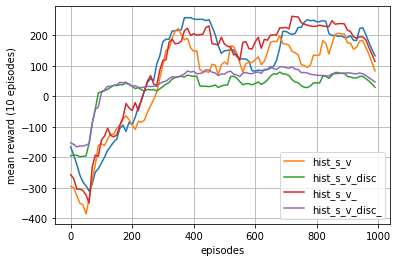

In [14]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(10)/10,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(10)/10,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(10)/10,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(10)/10,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [15]:
hist = np.array([[i for i in range(len(hist_s))],hist_s]).T

In [16]:
np.savetxt('st3.txt',hist)